### 下ごしらえ

In [0]:
import numpy as np
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from datetime import datetime
import time

Using TensorFlow backend.


In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 平坦化
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# 前処理
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

# 学習データをスプリット
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

## GetMiniBatchクラス

In [0]:
import numpy as np

class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

## 【問題1】全結合層のクラス化


In [0]:
import numpy as np

class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer                                   # 最適化インスタンスを保持
        self.W = initializer.W(n_nodes1, n_nodes2)     # 重み初期化
        self.B = initializer.B(n_nodes2)                          # バイアス初期化
        self.HW = 0                                                     #AdaGrad用
        self.HB = 0                                                      #AdaGrad用
        self.bZ = None                                                       # beforeZ
        self.dA = None                                                      # deltaA

    def forward(self, bZ):
        """
        フォワード
        Parameters
        ----------
        Z : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        
        # パラメータ更新で使うためインスタンス変数化
        self.bZ = bZ.copy()
        
        A = (bZ @ self.W) + self.B
        
        return A
    
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        
        # パラメータ更新で使うためインスタンス変数化
        self.dA = dA
        
        dZ = (dA @ self.W.T)
        
        # self.W self.Bの更新
        self = self.optimizer.update(self)
              
        return dZ

## 【問題2】初期化方法のクラス化

In [0]:
import numpy as np

class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    
    def __init__(self, sigma):
        self.sigma = sigma
        
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W : 次の形のndarray, shape (n_nodes1, n_nodes2)
          重さ
        """
        
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)

        return W


    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :次の形のndarray, shape (n_nodes2,)
          バイアス
        """
        
        B = self.sigma * np.random.randn(n_nodes2)
        
        return B

## 【問題3】最適化手法のクラス化

In [0]:
import numpy as np

class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    
    def __init__(self, lr):
        self.lr = lr
        
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        
        # 重みとバイアスを更新
        layer.W -= self.lr * (layer.bZ.T @ layer.dA) / len(layer.dA)
        layer.B -= np.mean(self.lr * layer.dA, axis=0)
        
        return layer

## 【問題4】活性化関数のクラス化
## 【問題5】ReLUクラスの作成

In [0]:
import numpy as np

class Sigmoid():
    """
    シグモイド汎用クラス
    
    Parameters
    -----------
    Z : 活性化後
    """
    
    def __init__(self):
        self.Z = None
        
    def forward(self, A):
        """
        シグモイド関数で活性化する
        
        Parameters
        -----------
        A : 入力(活性化前)
        
        Return
        -----------
        Z : 出力(活性化後)
        """
        
        # 入力の最大値
        sigmoid_range = 34.538776394910684
        
        self.Z = 1 / (1 + np.exp(-np.clip(A, -sigmoid_range, sigmoid_range)))
        
        return self.Z
    
    def backward(self, dZ):
        """
        シグモイド関数で活性化する
        
        Parameters
        -----------
        dZ : 入力(活性化前)
        
        Return
        -----------
        dA : 出力(活性化後)
        """

        dA = dZ * (self.Z * (1 - self.Z))
        
        return dA

In [0]:
import numpy as np

class Tanh():
    """
    ハイパボリックタンジェント汎用クラス
    
    Parameters
    -----------
    
    Attribute
    -----------
    self.Z : 活性化後
    """
    
    def __init__(self):
        self.Z = None
        
    def forward(self, A):
        """
        ハイパボリックタンジェント関数で活性化する
        
        Parameters
        -----------
        A : 入力(活性化前)
        
        Return
        -----------
        Z : 出力(活性化後)
        """
        
        self.Z = np.tanh(A)
        
        return self.Z
    
    def backward(self, dZ):
        """
        ハイパボリックタンジェント関数で活性化する
        
        Parameters
        -----------
        dZ : 入力(活性化前)
        
        Return
        -----------
        dA : 出力(活性化後)
        """
        
        dA = dZ * (1 - (self.Z ** 2))
        
        return dA

In [0]:
import numpy as np

class Softmax():
    """
    ソフトマックス汎用クラス
    """
        
    def forward(self, X):
        """
        ソフトマックス関数で予測する
        
        Parameters
        -----------
        X : 入力(活性化前)
        
        Return
        -----------
        Z : 出力(活性化後)
        """
        
        max_X = np.max(X)
        exp_X = np.exp(X - max_X)
        sum_exp_X = np.sum(exp_X, axis=1).reshape(-1, 1)
        
        Z = exp_X / sum_exp_X
        
        return Z
        
    
    def backward(self, Z, Y):
        """
        ソフトマックス関数で予測・交差エントロピーで誤差の算出をする
        
        Parameters
        -----------
        Z : 予測値
        Y : 正解値
        
        Return
        -----------
        dA : 出力
        """
        
        dA = Z - Y
        
        # 誤差を算出
        loss = - np.sum(Y * np.log(Z), axis=1)
        
        return dA, loss

In [0]:
import numpy as np

class ReLU():
    """
    ReLU汎用クラス
    """
    
    def __init__(self):
      self.mask = None
        
        
    def forward(self, A):
        """
        フォワードにおける活性化関数の計算
        
        Parameters
        -----------
        A : 入力(活性化前)
        
        Return
        -----------
        Z : 出力(活性化後)

        """
        
        self.mask = (A <= 0)
        Z = A.copy()
        Z[self.mask] = 0
        
        return Z
    
    
    def backward(self, dZ):
        """
        バックワードにおける活性化関数の計算
        
        Parameters
        -----------
        dZ : 入力(活性化前)
        
        Return
        -----------
        dA : 出力(活性化後)

        """
        
        dZ[self.mask] = 0
        dA = dZ
        
        return dA

## 【問題6】重みの初期値

In [0]:
import numpy as np

class XavierInitializer:
    """
    Xavierによる初期化
    """
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W : 次の形のndarray, shape (n_nodes1, n_nodes2)
          重さ
        """
        W = np.random.randn(n_nodes1, n_nodes2) / np.sqrt(n_nodes1)

        return W
    
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B : 次の形のndarray, shape (n_nodes2,)
          バイアス
        """
        B = np.zeros(n_nodes2)

        return B

In [0]:
import numpy as np

class HeInitializer:
    """
    Heによる初期化
    """
    
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W : 次の形のndarray, shape (n_nodes1, n_nodes2)
          重さ
        """
        
        W = np.random.randn(n_nodes1, n_nodes2) / np.sqrt(n_nodes1) * np.sqrt(2)

        return W
    
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B : 次の形のndarray, shape (n_nodes2,)
          バイアス
        """
        
        B = np.zeros(n_nodes2)

        return B

## 【問題7】最適化手法

In [0]:
import numpy as np

class AdaGrad:
    """
    AdaGradによる最適化手法
    Parameters
    ----------
    lr : 学習率
    """    
    def __init__(self, lr):
        self.lr = lr
        
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        
        # 重みとバイアスを更新
        layer.HW += ((layer.bZ.T @ layer.dA) / len(layer.dA)) ** 2
        layer.W -= self.lr * (1 / np.sqrt(layer.HW + 1e-7)) * ((layer.bZ.T @ layer.dA) / len(layer.dA))
        layer.HB += (layer.dA) ** 2        
        layer.B -= np.mean(self.lr * (1 / np.sqrt(layer.HB + 1e-7)) * layer.dA)

        
        return layer

## ScratchDeepNeuralNetworkClassifierクラス

In [0]:
import numpy as np
import logging                                                                     # ログ
from datetime import datetime                                        # 時間のやつ
from sklearn.preprocessing import OneHotEncoder       # ワンホットのやつ
from tqdm import tqdm                                                     # 進捗バーを出してくれるやつ


class ScratchDeepNeuralNetworkClassifier():
    """
    ニューラルネットワーク分類器
    """

    def __init__(self, batch_size=10, n_epochs=10,  n_nodes=400, layer=4, verbose=True,
                            sigma=1e-2, lr=1e-2, activation=None, optimizer='sgd'):

        self.batch_size = batch_size     # バッチサイズ
        self.n_epochs = n_epochs         # エポック数 
        self.n_input = n_nodes              # 初回のノード数
        self.layer = layer                          # 層の数
        self.verbose = verbose               # 学習過程出力フラグ
        self.activation = activation        #活性化関数(文字列)
        self.FCs = []                                  # FCインスタンス格納用
        self.activations = []                     # 活性化関数インスタンス格納用
        self.loss_ = []                              # 学習用データの学習過程格納用
        self.loss_val_ = []                       # 検証用データの学習過程格納用
        
        # 初期化・最適化クラスインスタンス作成
        if activation == 'relu':
            self.initializer = HeInitializer()
        else:
            self.initializer = XavierInitializer()
        
        if optimizer == 'sgd':
            self.optimizer = SGD(lr)
        elif optimizer == 'adagrad':
            self.optimizer = AdaGrad(lr)
            
        # ワンホットライブラリのインスタンス作成
        self.enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        
        # ログレベルを DEBUG に変更
        time_stamp = datetime.now().strftime('%Y%m%d')
        logging.basicConfig(filename='../tmp/sprint11_' + time_stamp + '.log', level=logging.DEBUG)
        
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        
        # ワンホット化
        y = self.enc.fit_transform(y[:, np.newaxis])
        
        # 検証用データがある場合
        if X_val is not None:
            y_val= self.enc.fit_transform(y_val[:, np.newaxis])


        # 学習用データから特徴量とクラス数を取得
        n_features = X.shape[1]
        n_output = y.shape[1]

        # 初期化
        n_nodes1 = self.n_input
        
        # 各層のFCインスタンス作成
        for i in range(self.layer):
            if i == (self.layer - 1):     # 出力層
                fc = FC(n_nodes2, n_output, self.initializer, self.optimizer)
                activation = Softmax()
            else:
                if i == 0:                       # 入力層
                    fc = FC(n_features, n_nodes1, self.initializer, self.optimizer)
                else:
                    n_nodes2 = int(n_nodes1 / 2)   # TODO: 多分よロしくない
                    fc = FC(n_nodes1, n_nodes2, self.initializer, self.optimizer)
                    n_nodes1 = n_nodes2
                
                # 出力層以外は指定された活性化関数をインスタンス化
                if self.activation == 'sigmoid':
                    activation = Sigmoid()
                elif self.activation == 'tanh':
                    activation = Tanh()
                elif self.activation == 'relu':
                    activation = ReLU()
                
            self.FCs.append(fc)                           # 各自格納
            self.activations.append(activation)


        # エポックごとに進捗率を計測
        for e in tqdm(range(self.n_epochs)):
            # ミニバッチ化
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            # ロス格納用
            loss_ary = []
            
            # Xのn_samples / batch_size数分ループ処理
            for mini_X_train, mini_y_train in get_mini_batch:
                                            
                # forward propagation
                for i in range(self.layer):
                    if i == 0:                              # 入力層
                        A = self.FCs[i].forward(mini_X_train)
                        Z = self.activations[i].forward(A)
                    else:
                        A = self.FCs[i].forward(Z)
                        Z = self.activations[i].forward(A)
                
                # back propagation
                for i in range(self.layer):
                    n_FC = self.layer - i - 1      # インスタンス逆指定用
                    if i == 0:                               # 入力層
                        dA, loss = self.activations[n_FC].backward(Z, mini_y_train)
                        loss_ary.append(loss)
                    else:                                     # 出力層
                        dA = self.activations[n_FC].backward(dZ)
                        
                    dZ = self.FCs[n_FC].backward(dA)

                    
            #誤差を格納
            self.loss_.append(np.mean(loss_ary))
                        
            # 検証用データがある場合
            if X_val is not None:
                # forward propagation
                for i in range(self.layer):
                    if i == 0:                              # 入力層
                        A = self.FCs[i].forward(X_val)
                        Z = self.activations[i].forward(A)
                    else:
                        A = self.FCs[i].forward(Z)
                        Z = self.activations[i].forward(A)
                
                # 
                dA, loss_val = self.activations[self.layer-1].backward(Z, y_val)

                #誤差を格納
                self.loss_val_.append(np.mean(loss_val))
                            

            # フラグがTrueであればログ出力
            if self.verbose:
                logging.info('forward propagation %sエポック目 sum: %s shape: %s', e+1, np.sum(A), A.shape)
                logging.info('forward propagation %sエポック目 sum: %s shape: %s', e+1, np.sum(Z), Z.shape)
                logging.info('backward propagation %sエポック目 sum: %s shape: %s', e+1, np.sum(dA), dA.shape)
                logging.info('backward propagation %sエポック目 sum: %s shape: %s', e+1, np.sum(dZ), dZ.shape)
                logging.info('loss %sエポック目 : %s', e+1, np.sum(loss))

        return self


    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習データ

        Returns
        -------
        y_pred :  次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        
        # forward propagation
        for i in range(self.layer):
            if i == 0:                              # 入力層
                A = self.FCs[i].forward(X)
                Z = self.activations[i].forward(A)
            else:
                A = self.FCs[i].forward(Z)
                Z = self.activations[i].forward(A)
        
        # 一番確率が高いラベルを予測値に
        y_pred = np.argmax(Z, axis=1)
        
        return y_pred
    

## 試してみる
### sigmoid(XavierInitializer) と sgd 

In [15]:
sdnnc= ScratchDeepNeuralNetworkClassifier(activation='sigmoid')

sdnnc.fit(X_train, y_train, X_val, y_val)

100%|██████████| 10/10 [03:58<00:00, 23.78s/it]


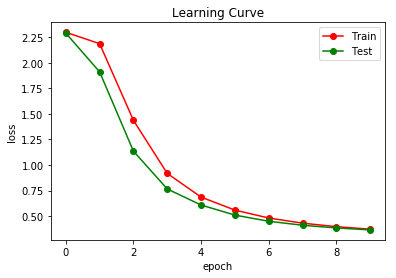

In [16]:
train_loss = np.array(sdnnc.loss_)
test_loss = np.array(sdnnc.loss_val_)

plt.title("Learning Curve")
plt.xlabel("epoch")
plt.ylabel("loss")

# Traing score と Test score をプロット
plt.plot(train_loss, 'o-', color="r", label="Train")
plt.plot(test_loss, 'o-', color="g", label="Test")

plt.legend(loc=1)
plt.show()

In [17]:
# 予測
y_pred = sdnnc.predict(X_val)

print(confusion_matrix(y_val, y_pred))
print(accuracy_score(y_val, y_pred))

[[1083    0    4    3    1   23    3    1    5    2]
 [   0 1310   13    1    1   13    3    6   26    2]
 [  23   17 1012   38   21    2   35    6   35    4]
 [   3   11   38  993    1  103    2   14   32    7]
 [  10    4    3    0 1095    2   18    3    6   52]
 [  10    2    6   31    8  974   27    1   24   10]
 [  17    4    8    0   27   21 1143    0    1    0]
 [   4    9   15    6   13    6    0 1132    1   51]
 [   5   18   22   34    5   64   19    0  963   30]
 [   6    3    0    7   72   16    0   47   16 1032]]
0.89475


できてそう 他も2,3こ試してみる
### tanh(XavierInitializer) と sgd 

In [18]:
sdnnc= ScratchDeepNeuralNetworkClassifier(activation='tanh')

sdnnc.fit(X_train, y_train, X_val, y_val)

100%|██████████| 10/10 [04:05<00:00, 24.09s/it]


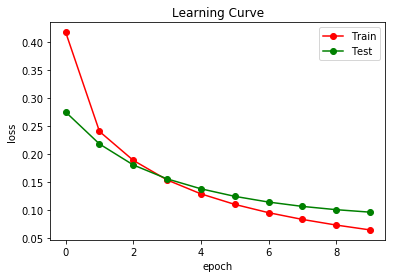

In [19]:
train_loss = np.array(sdnnc.loss_)
test_loss = np.array(sdnnc.loss_val_)

plt.title("Learning Curve")
plt.xlabel("epoch")
plt.ylabel("loss")

# Traing score と Test score をプロット
plt.plot(train_loss, 'o-', color="r", label="Train")
plt.plot(test_loss, 'o-', color="g", label="Test")

plt.legend(loc=1)
plt.show()

In [20]:
# 予測
y_pred = sdnnc.predict(X_val)

print(confusion_matrix(y_val, y_pred))
print(accuracy_score(y_val, y_pred))

[[1110    0    2    2    0    6    2    0    1    2]
 [   0 1353    6    4    3    2    0    4    3    0]
 [   8    5 1148    6   10    0    1    8    7    0]
 [   4    4    7 1161    2   12    0    6    6    2]
 [   1    2    2    0 1171    2    2    1    1   11]
 [   2    0    0   14    1 1065    3    0    6    2]
 [   8    3    0    0    1   13 1193    1    2    0]
 [   1    1    6    2   10    1    1 1205    3    7]
 [   1    4    9   20    2   10    1    2 1098   13]
 [   1    4    1    6   21   10    0   12    4 1140]]
0.9703333333333334


### relu(XavierInitializer) と adagrad

In [21]:
sdnnc= ScratchDeepNeuralNetworkClassifier(activation='relu', optimizer='adagrad')

sdnnc.fit(X_train, y_train, X_val, y_val)

100%|██████████| 10/10 [08:08<00:00, 47.77s/it]


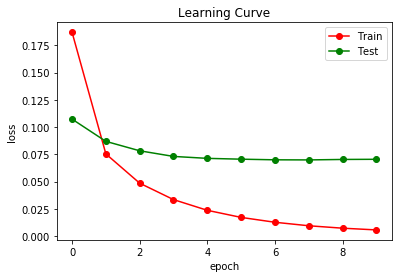

In [22]:
train_loss = np.array(sdnnc.loss_)
test_loss = np.array(sdnnc.loss_val_)

plt.title("Learning Curve")
plt.xlabel("epoch")
plt.ylabel("loss")

# Traing score と Test score をプロット
plt.plot(train_loss, 'o-', color="r", label="Train")
plt.plot(test_loss, 'o-', color="g", label="Test")

plt.legend(loc=1)
plt.show()

In [23]:
# 予測
y_pred = sdnnc.predict(X_val)

print(confusion_matrix(y_val, y_pred))
print(accuracy_score(y_val, y_pred))

[[1114    0    2    1    0    1    1    1    3    2]
 [   0 1361    3    3    2    1    0    4    1    0]
 [   3    5 1169    4    3    0    0    4    5    0]
 [   1    0    9 1177    0    7    0    4    4    2]
 [   0    0    3    0 1172    0    3    2    1   12]
 [   2    0    1    9    0 1068    6    0    4    3]
 [   1    2    0    0    3    5 1208    0    2    0]
 [   0    2    6    1    5    1    0 1214    2    6]
 [   4    5    5    9    1    4    4    1 1123    4]
 [   1    4    1    4    8    2    0    6    5 1168]]
0.9811666666666666


## メモ
- 各層のnode数を根拠なしに指定してしまっているので、調査したい
- adagradにすると1エポックあたりの処理が50秒近くかかってしまっているので、改善したい

### 寄り道

In [0]:
# ログを出す
import logging
from datetime import datetime

# タイムスタンプ作成
time_stamp = datetime.now().strftime('%Y%m%d')

# ログレベルを DEBUG に変更
logging.basicConfig(filename='../log/' + time_stamp + '.log', level=logging.DEBUG)

logging.info('info %s %s', 'hoge', 'fuga')